# Project Milestone 1

### Import Packages and Data

In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

warnings.filterwarnings('ignore')                 # some warnings are repressed

In [3]:
df = pd.read_csv('anon_data.csv')

### Notes

This dataset was built off of real data from a large insurance company. Prior to reading the data, it was anonymized, as well as many of the columns and values being altered to not reflect their original value. Further, additional termination data is randomized within the dataset in order to allow a large enough sample for analysis. 

## Exploratory Data Analysis

Before beginning any data cleaning/transformation or analysis, let us take a look at the structure of our data.

### View Data

In [4]:
# first 5 columns
# employee id has been anonymized prior to loading
df[['EMPLOYEE_ID', 'IS_CURRENTLY_ACTIVE_IND', 'ANNUAL_SALARY', 'DEPARTMENT', 'LESS_THAN_1YR_IND']].head()

,EMPLOYEE_ID,IS_CURRENTLY_ACTIVE_IND,ANNUAL_SALARY,DEPARTMENT,LESS_THAN_1YR_IND
0,a5a4928ec6bb210505851f5b92a4724fcac7b54a5f8005...,1,46238.40,882,0
1,8695430f4f8a7587f6b62bb855a757a6f3fa098688d104...,1,52208.00,882,0
2,cbf98ef024c88c8f00faae4cefa5a6330f6a3e433ad95c...,1,42931.20,882,0
3,cbf98ef024c88c8f00faae4cefa5a6330f6a3e433ad95c...,1,43950.40,882,0
4,cb4573ba1151aaa938786ab521f7cdc96b8f56b56835ce...,1,111476.59,882,0


In [5]:
# next 5 columns
df[['GENDER', 'ETHNICITY_GROUP', 'GENERATION_DESCRIPTION', 'LOCATION_GROUP', 'MANAGER_INDICATOR']].head()

,GENDER,ETHNICITY_GROUP,GENERATION_DESCRIPTION,LOCATION_GROUP,MANAGER_INDICATOR
0,Men,White,Generation Y / Millennials (1981 -1996),Full-Time Remote,N
1,Men,White,Generation X (1965 -1980),Full-Time Remote,N
2,Women,Hispanic or Latino,Generation Y / Millennials (1981 -1996),Full-Time Remote,N
3,Women,Hispanic or Latino,Generation Y / Millennials (1981 -1996),Full-Time Remote,N
4,Men,White,Baby Boomers (1946-1964),Full-Time Remote,N


In [6]:
# next 5 columns
df[['TERMINATION_COUNT', 'TERMINATION_DATE', 'TIME_OFF_DATE', 'TOTAL_HOURS_APPROVED', 'HOURS_DENIED']].head()

,TERMINATION_COUNT,TERMINATION_DATE,TIME_OFF_DATE,TOTAL_HOURS_APPROVED,HOURS_DENIED
0,0,NaN,2022-03-15,3.33,0.0
1,0,NaN,2022-03-17,4.00,0.0
2,0,NaN,2022-04-20,8.00,0.0
3,0,NaN,2022-04-27,2.50,0.0
4,0,NaN,2022-03-03,8.00,0.0


In [7]:
# next (and final_ 3 columns
df[['HOURS_CANCELLED', 'FINAL_USED_HOURS', 'FINAL_STATUS']].head()

,HOURS_CANCELLED,FINAL_USED_HOURS,FINAL_STATUS
0,0.0,3.33,APPROVED
1,0.0,4.00,APPROVED
2,0.0,8.00,APPROVED
3,0.0,2.50,APPROVED
4,0.0,8.00,APPROVED


### Transform Data

Although much work was done on this data prior to being uploaded in order to prepare it for analysis, some additional work is needed. Below, we will add additional termination values to allow for a large enough sample. We will also drop the termination date, as terminated individuals terminated in the month of their last time off date. This will be used to identify their termination month. Additionally, time off date is converted to a date type in order to allow extraction of the month. September, October, November, and December are being dropped from the dataset due to incomplete information. Analysis will be performed on data from January through August. Finally, the generation column is simplified.

In [8]:
# create additional terminated employees to allow for a large enough sample for modeling
df['TERMINATION_COUNT'] = df['TERMINATION_COUNT'].sample(n = 1000, random_state = 12).replace(0, 1)
# 0's are turned into NaN after replace, so turn them back into 0
df['TERMINATION_COUNT'] = df['TERMINATION_COUNT'].fillna(0)

# separate terms and non-terms
terms = df.loc[df['TERMINATION_COUNT'] == 1]
non_terms = df.loc[df['TERMINATION_COUNT'] == 0]

# make sure one employee does not have more than 1 termination
terms = terms.drop_duplicates(subset = ["EMPLOYEE_ID", "TERMINATION_COUNT"], keep = 'first')

# re-combine terms and non-terms after assuring only 1 term per person
df = pd.concat([terms, non_terms])

In [9]:
# select all termination instances
termed = df.loc[df['TERMINATION_COUNT'] == 1]

# build list of termed employees
termed = termed['EMPLOYEE_ID'].tolist()

# make all termed individuals not currently active with IS_CURRENTLY_ACTIVE_IND
df['IS_CURRENTLY_ACTIVE_IND'] = df['EMPLOYEE_ID'].isin(termed).astype(int)

# above assigns opposite as expected, this changes to clear yes/no
df.loc[df["IS_CURRENTLY_ACTIVE_IND"] == 0, "IS_CURRENTLY_ACTIVE_IND"] = 'YES'
df.loc[df["IS_CURRENTLY_ACTIVE_IND"] == 1, "IS_CURRENTLY_ACTIVE_IND"] = 'NO'

In [10]:
# if an employee terminated, they terminated in the month of their final time off date
# thus, we do not need an exact time off date
df = df.drop(['TERMINATION_DATE'], axis = 1)

In [11]:
# converts date strings to date type for ease of use
df['TIME_OFF_DATE'] = pd.to_datetime(df['TIME_OFF_DATE'], format = '%Y-%m-%d')

In [12]:
# extract month of time off date
df['TIME_OFF_MONTH'] = pd.DatetimeIndex(df['TIME_OFF_DATE']).month

In [13]:
# data is missing from months 9-12. We will drop these months for the sake of this analysis
# this is due to a data load issue at my company that is being addressed, but for now this data is not
# accurate and should not be considered
df = df[df['TIME_OFF_MONTH'] != 9]
df = df[df['TIME_OFF_MONTH'] != 10]
df = df[df['TIME_OFF_MONTH'] != 11]
df = df[df['TIME_OFF_MONTH'] != 12]

In [14]:
# simplify generation names
df.loc[df["GENERATION_DESCRIPTION"] == 'Baby Boomers (1946-1964)', 
        "GENERATION_DESCRIPTION"] = 'Baby Boomers'
df.loc[df["GENERATION_DESCRIPTION"] == 'Generation X (1965 -1980)', 
        "GENERATION_DESCRIPTION"] = 'Gen X'
df.loc[df["GENERATION_DESCRIPTION"] == 'Generation Y / Millennials (1981 -1996)', 
        "GENERATION_DESCRIPTION"] = 'Millennials'
df.loc[df["GENERATION_DESCRIPTION"] == 'Generation Z (1997 and onwards)', 
        "GENERATION_DESCRIPTION"] = 'Gen Z'
df.loc[df["GENERATION_DESCRIPTION"] == 'Silent Generation (1928 -1945)', 
        "GENERATION_DESCRIPTION"] = 'Silent Generation'

### Visualization

The first visualization we are interested in is comparing termination across time with absences across time. The plot below will show termination count and absence count by month across the year.

In [15]:
# count time off days by month
monthly_counts = df.groupby(['TIME_OFF_MONTH'])['TIME_OFF_DATE'].size().to_frame().reset_index()

In [16]:
# convert numeric months to strings
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 1, "TIME_OFF_MONTH"] = 'Jan'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 2, "TIME_OFF_MONTH"] = 'Feb'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 3, "TIME_OFF_MONTH"] = 'Mar'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 4, "TIME_OFF_MONTH"] = 'Apr'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 5, "TIME_OFF_MONTH"] = 'May'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 6, "TIME_OFF_MONTH"] = 'Jun'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 7, "TIME_OFF_MONTH"] = 'Jul'
monthly_counts.loc[monthly_counts["TIME_OFF_MONTH"] == 8, "TIME_OFF_MONTH"] = 'Aug'

In [17]:
# count terminations by month
term_counts = df.groupby(['TIME_OFF_MONTH'])['TERMINATION_COUNT'].sum().to_frame().reset_index()

In [18]:
# convert numeric months to strings
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 1, "TIME_OFF_MONTH"] = 'Jan'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 2, "TIME_OFF_MONTH"] = 'Feb'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 3, "TIME_OFF_MONTH"] = 'Mar'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 4, "TIME_OFF_MONTH"] = 'Apr'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 5, "TIME_OFF_MONTH"] = 'May'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 6, "TIME_OFF_MONTH"] = 'Jun'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 7, "TIME_OFF_MONTH"] = 'Jul'
term_counts.loc[term_counts["TIME_OFF_MONTH"] == 8, "TIME_OFF_MONTH"] = 'Aug'

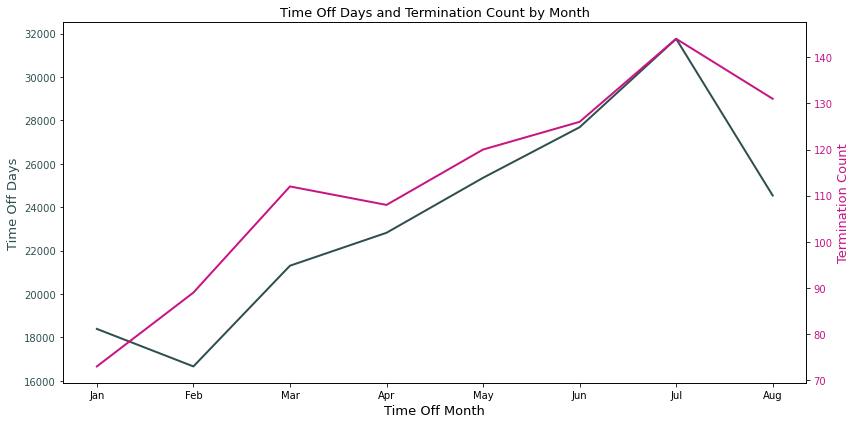

In [19]:
# store data
x = monthly_counts['TIME_OFF_MONTH'].tolist()
y1 = monthly_counts['TIME_OFF_DATE'].tolist()
y2 = term_counts['TERMINATION_COUNT'].tolist()

# plotting and labeling
fig, ax1 = plt.subplots(figsize = (12, 6))

ax1.set_xlabel('Time Off Month', fontsize = 13)
ax1.set_title("Time Off Days and Termination Count by Month", fontsize = 13)
ax1.set_ylabel('Time Off Days', color = 'darkslategray', 
              fontsize = 13)
ax1.plot(x, y1, color = 'darkslategray', linewidth = 2)
ax1.tick_params(axis = 'y', labelcolor = 'darkslategray')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Termination Count', color = 'mediumvioletred',
              fontsize = 13)  # we already handled the x-label with ax1
ax2.plot(x, y2, color = 'mediumvioletred', linewidth = 2)
ax2.tick_params(axis = 'y', labelcolor = 'mediumvioletred')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

If our original hypothesis that absences align with termination is correct, we should expect to see each of the lines above to follow the same trend. Although there is some variation between the two lines, the overall pattern does appear to be similar, with the lowest number of terminations being around the same time as the lowest number of absences, and the largest number of terminations being around the same time as the largest number of absences. Thus, this plot may suggest that those who are going to terminate take more time off in the month of their termination.

In [20]:
# separate out terminated employees and find count of time off by month, per employee
all_terms = df.loc[df['IS_CURRENTLY_ACTIVE_IND'] == 'NO']
time_off_terms = all_terms.groupby(['EMPLOYEE_ID','TIME_OFF_MONTH'])['TIME_OFF_DATE'].count().to_frame().reset_index()

In [21]:
# separate out active employees and find count of time off by month, per employee
all_reg = df.loc[df['IS_CURRENTLY_ACTIVE_IND'] == 'YES']
time_off_reg = all_reg.groupby(['EMPLOYEE_ID','TIME_OFF_MONTH'])['TIME_OFF_DATE'].count().to_frame().reset_index()

In [22]:
# find average time off by month (dividing by term population) for terminated employees
by_month_term = time_off_terms.groupby(['TIME_OFF_MONTH'])['TIME_OFF_DATE'].sum()/len(all_terms\
                                                                                      ['EMPLOYEE_ID'].unique())
by_month_term = by_month_term.to_frame().reset_index()

In [23]:
# find average time off by month (dividing by active population) for active employees
by_month_active = time_off_reg.groupby(['TIME_OFF_MONTH'])['TIME_OFF_DATE'].sum()/len(all_reg\
                                                                                      ['EMPLOYEE_ID'].unique())
by_month_active = by_month_active.to_frame().reset_index()

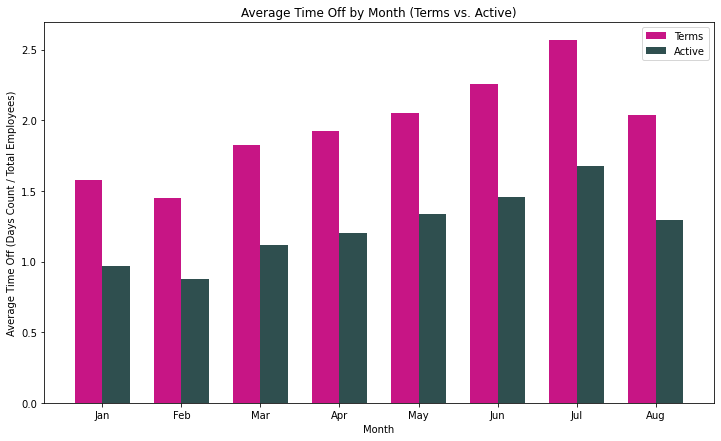

In [24]:
# number of bar pairs
N = 8

# term data
term_data = by_month_term['TIME_OFF_DATE'].tolist()
# active data
active_data = by_month_active['TIME_OFF_DATE'].tolist()

# position of bars on x-axis
ind = np.arange(N)

# figure size
plt.figure(figsize = (12,7))

# width of a bar 
width = 0.35       

# plotting and labeling
plt.bar(ind, term_data , width, label = 'Terms', color = 'mediumvioletred')
plt.bar(ind + width, active_data, width, label = 'Active', color = 'darkslategray')

plt.xlabel('Month')
plt.ylabel('Average Time Off (Days Count / Total Employees)')
plt.title('Average Time Off by Month (Terms vs. Active)')

# where ticks should be placed and labels to be placed
plt.xticks(ind + width / 2,
          ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'))

# finding the best position for legends
plt.legend(loc = 'best')
plt.show()

The next plot we are interested in looking at is average time off by month for those who have terminated and those who are active. By looking at this graph, rather than simply looking at monthly trends, we can also look at trends across the year to see if employees are more likely to take a higher number of absences across the year before termination. As is evident by the plot above, the average number of absences taken is higher for those who terminate in that year, per month, while the average number of absences taken is lower for those who are active employees throughout the entire year. This supports the prior plot.

In [25]:
# build data (sum of terminations by department)
data = [df.groupby(['DEPARTMENT'])['TERMINATION_COUNT'].sum().to_frame().reset_index()['DEPARTMENT'].tolist(),
    df.groupby(['DEPARTMENT'])['TERMINATION_COUNT'].sum().to_frame().reset_index()['TERMINATION_COUNT'].tolist(),
       df.groupby(['DEPARTMENT'])['EMPLOYEE_ID'].count().to_frame().reset_index()['EMPLOYEE_ID'].tolist()]

# format data and average across employees
dpmt = pd.DataFrame(data)
dpmt = dpmt.transpose().values.tolist()
dpmt = pd.DataFrame(dpmt)
dpmt.rename(columns = {0 : 'DEPARTMENT', 1 : 'TERMINATION_COUNT', 2 : 'EMPLOYEE_COUNT'}, inplace = True)
dpmt["AVERAGE_TERM_PER_THOUSAND"] = round(dpmt["TERMINATION_COUNT"]/dpmt["EMPLOYEE_COUNT"], 5) * 1000
dpmt['DEPARTMENT'] = dpmt['DEPARTMENT'].astype(int)

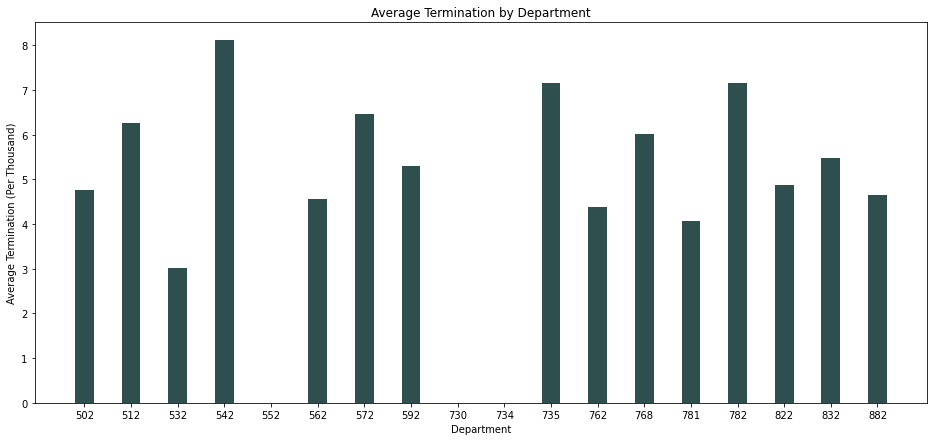

In [26]:
# set indices and width
ind = np.arange(18)
width = 0.4

fig = plt.figure(figsize = (16, 7))
 
# creating the bar plot and labels
plt.bar(ind, dpmt['AVERAGE_TERM_PER_THOUSAND'], color = 'darkslategray',
        width = width)
 
plt.xlabel("Department")
plt.ylabel("Average Termination (Per Thousand)")
plt.title("Average Termination by Department")
plt.xticks(ind,
          ('502', '512', '532', '542', '552', '562', '572', '592', '730', '734',
          '735', '762', '768', '781', '782', '822', '832', '882'))
plt.show()

To take a look at some of the additional factors we wish to examine, we next examine the average number of terminations (per 1,000 employees) for each department within the organization. The plot above suggests that there are only slight differences between the departments, with the largest difference being a high rate of termination in department 754. 

In [27]:
# build data (sum of terminations by department)
data = [df.groupby(['GENERATION_DESCRIPTION'])['TERMINATION_COUNT'].sum().to_frame().reset_index()\
        ['GENERATION_DESCRIPTION'].tolist(),
        df.groupby(['GENERATION_DESCRIPTION'])['TERMINATION_COUNT'].sum().to_frame().reset_index()\
        ['TERMINATION_COUNT'].tolist(),
       df.groupby(['GENERATION_DESCRIPTION'])['EMPLOYEE_ID'].count().to_frame().reset_index()\
        ['EMPLOYEE_ID'].tolist()]

# format data and average across employees
gen = pd.DataFrame(data)
gen = gen.transpose().values.tolist()
gen = pd.DataFrame(gen)
gen.rename(columns = {0 : 'GENERATION_DESCRIPTION', 1 : 'TERMINATION_COUNT', 2 : 'EMPLOYEE_COUNT'}, inplace = True)
gen["AVERAGE_TERM_PER_THOUSAND"] = round(gen["TERMINATION_COUNT"]/gen["EMPLOYEE_COUNT"], 5) * 1000

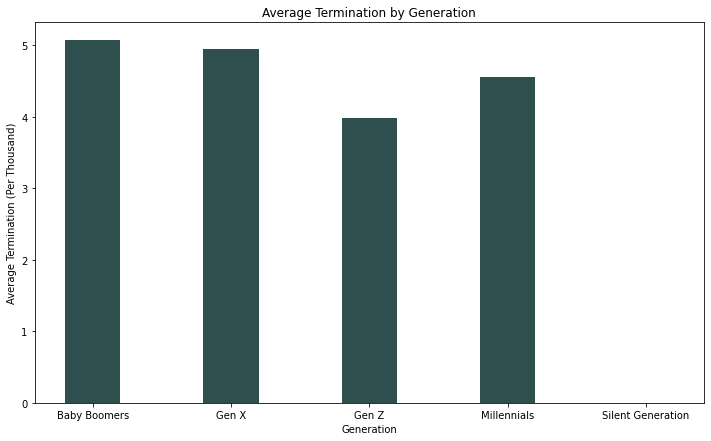

In [28]:
# set indices and width
ind = np.arange(5)
width = 0.4

fig = plt.figure(figsize = (12, 7))
 
# creating the bar plot and labels
plt.bar(ind, gen['AVERAGE_TERM_PER_THOUSAND'], color = 'darkslategray',
        width = width)
 
plt.xlabel("Generation")
plt.ylabel("Average Termination (Per Thousand)")
plt.title("Average Termination by Generation")
plt.xticks(ind,
          ('Baby Boomers', 'Gen X', 'Gen Z', 'Millennials', 'Silent Generation'))
plt.show()

Looking now at termination across generations, although there are slight differences, these are not likely to be statistically significant. There does not appear to be much of a relationship between age and termination.

In [29]:
# build data (sum of terminations by time in job)
data = [df.groupby(['LESS_THAN_1YR_IND'])['TERMINATION_COUNT'].sum().to_frame().reset_index()\
        ['LESS_THAN_1YR_IND'].tolist(),
        df.groupby(['LESS_THAN_1YR_IND'])['TERMINATION_COUNT'].sum().to_frame().reset_index()\
        ['TERMINATION_COUNT'].tolist(),
       df.groupby(['LESS_THAN_1YR_IND'])['EMPLOYEE_ID'].count().to_frame().reset_index()\
        ['EMPLOYEE_ID'].tolist()]

# format data and average across employees
tim = pd.DataFrame(data)
tim = tim.transpose().values.tolist()
tim = pd.DataFrame(tim)
tim.rename(columns = {0 : 'LESS_THAN_1YR_IND', 1 : 'TERMINATION_COUNT', 2 : 'EMPLOYEE_COUNT'}, inplace = True)
tim["AVERAGE_TERM_PER_THOUSAND"] = round(tim["TERMINATION_COUNT"]/tim["EMPLOYEE_COUNT"], 5) * 1000

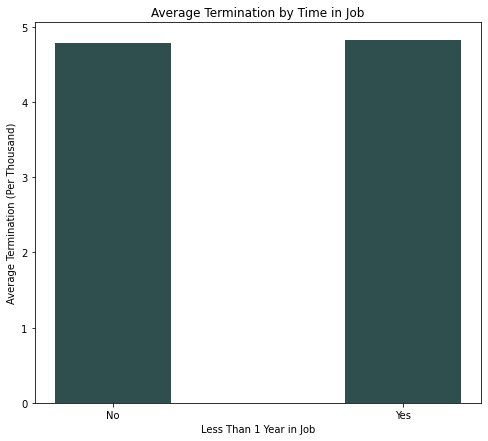

In [30]:
# set indices and width
ind = np.arange(2)
width = 0.4

fig = plt.figure(figsize = (8, 7))
 
# creating the bar plot and labels
plt.bar(ind, tim['AVERAGE_TERM_PER_THOUSAND'], color = 'darkslategray',
        width = width)
 
plt.xlabel("Less Than 1 Year in Job")
plt.ylabel("Average Termination (Per Thousand)")
plt.title("Average Termination by Time in Job")
plt.xticks(ind,
          ('No', 'Yes'))
plt.show()

Looking now at termination across time spent in job, we have those who have been in the job less than 1 year, and those who have been in the job more than 1 year. It appears that there is no difference between the two.

In [31]:
# break salary into groups using quantiles
df['SALARY_QUANTILE'] = pd.qcut(df['ANNUAL_SALARY'], q = 6)

# convert to string from interval
df['SALARY_QUANTILE'] = df['SALARY_QUANTILE'].values.astype('string')

# turns quantile intervals into groups
df.loc[df["SALARY_QUANTILE"] == '(-0.001, 44595.2]', "SALARY_GROUP"] = 1
df.loc[df["SALARY_QUANTILE"] == '(44595.2, 55016.0]', "SALARY_GROUP"] = 2
df.loc[df["SALARY_QUANTILE"] == '(55016.0, 69136.0]', "SALARY_GROUP"] = 3
df.loc[df["SALARY_QUANTILE"] == '(69136.0, 90000.0]', "SALARY_GROUP"] = 4
df.loc[df["SALARY_QUANTILE"] == '(90000.0, 122500.0]', "SALARY_GROUP"] = 5
df.loc[df["SALARY_QUANTILE"] == '(122500.0, 950000.0]', "SALARY_GROUP"] = 6

# converrt groups to integer from float
df['SALARY_GROUP'] = df['SALARY_GROUP'].values.astype('int')

In [32]:
# build data (sum of terminations by salary group)
data = [df.groupby(['SALARY_GROUP'])['TERMINATION_COUNT'].sum().to_frame().reset_index()\
        ['SALARY_GROUP'].tolist(),
        df.groupby(['SALARY_GROUP'])['TERMINATION_COUNT'].sum().to_frame().reset_index()\
        ['TERMINATION_COUNT'].tolist(),
       df.groupby(['SALARY_GROUP'])['EMPLOYEE_ID'].count().to_frame().reset_index()\
        ['EMPLOYEE_ID'].tolist()]

# format data and average across employees
sal = pd.DataFrame(data)
sal = sal.transpose().values.tolist()
sal = pd.DataFrame(sal)
sal.rename(columns = {0 : 'SALARY_GROUP', 1 : 'TERMINATION_COUNT', 2 : 'EMPLOYEE_COUNT'}, inplace = True)
sal["AVERAGE_TERM_PER_THOUSAND"] = round(sal["TERMINATION_COUNT"]/sal["EMPLOYEE_COUNT"], 5) * 1000

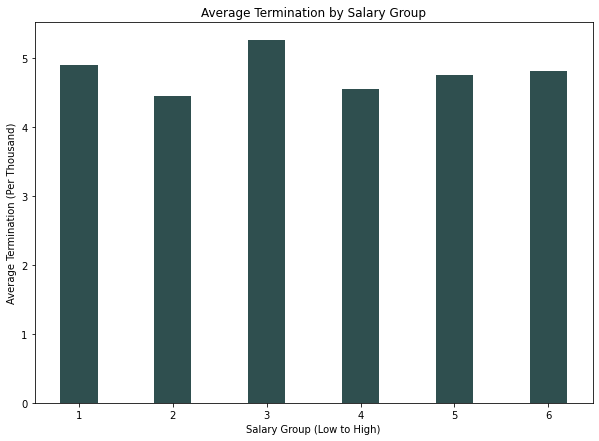

In [33]:
# set indices and width
ind = np.arange(6)
width = 0.4

fig = plt.figure(figsize = (10, 7))
 
# creating the bar plot and labels
plt.bar(ind, sal['AVERAGE_TERM_PER_THOUSAND'], color = 'darkslategray',
        width = width)
 
plt.xlabel("Salary Group (Low to High)")
plt.ylabel("Average Termination (Per Thousand)")
plt.title("Average Termination by Salary Group")
plt.xticks(ind,
          (1, 2, 3, 4, 5, 6))
plt.show()

To look at our final variable of interest, we want to see if salary impacts termination rate, with 1 being a lower salary and 6 being the highest salary range. Although there are slight differences, there does not appear to be much of a relatioonship between salary and termination.

### EDA Conclusion

After looking at absence and termination data across the year, along with examining termination rate across individual features, there does appear to be a relationship between termination and absence, as well as a relationship between termination and department and time spent in the job. There is not as clear of a relationship between termination and generation and salary, although additional analysis is needed to confirm or deny the statistical significance of these differences. 

# Project Milestone 2

### Import Additional Packages

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from imblearn.over_sampling import RandomOverSampler

## Data Preparation

### View Data

In [35]:
# first 6 columns
df[['EMPLOYEE_ID', 'IS_CURRENTLY_ACTIVE_IND', 'ANNUAL_SALARY', 'DEPARTMENT', 'LESS_THAN_1YR_IND', 'GENDER']].head(5)

,EMPLOYEE_ID,IS_CURRENTLY_ACTIVE_IND,ANNUAL_SALARY,DEPARTMENT,LESS_THAN_1YR_IND,GENDER
200,80941dcdd6dd4d599bd99010e5e5c5a3fe0470af113a1a...,NO,72758.4,882,0,Women
299,6152a4af8aaf0c00b840f040766280214c103ab23f59e6...,NO,43888.0,882,0,Women
432,594a7465713e99115dbc5d1de3364bf04a198bfe835012...,NO,79100.0,822,0,Women
497,1b7984a1ea288b9b1541da621e6b7ba3f2dba42166dfc9...,NO,37252.8,882,0,Women
540,c8b9b957b9e3a9f9b1b871fa9034c31655e049832212fc...,NO,89500.0,822,0,Women


In [36]:
# next 6 columns
df[['ETHNICITY_GROUP', 'GENERATION_DESCRIPTION', 'LOCATION_GROUP', 'MANAGER_INDICATOR', 'TERMINATION_COUNT',
   'TIME_OFF_DATE']].head(5)

,ETHNICITY_GROUP,GENERATION_DESCRIPTION,LOCATION_GROUP,MANAGER_INDICATOR,TERMINATION_COUNT,TIME_OFF_DATE
200,Hispanic or Latino,Millennials,HUB,N,1.0,2022-06-10
299,Black or African American,Gen X,Full-Time Remote,N,1.0,2022-03-08
432,White,Gen X,Full-Time Remote,N,1.0,2022-03-25
497,Black or African American,Millennials,Full-Time Remote,N,1.0,2022-03-24
540,White,Baby Boomers,Full-Time Remote,N,1.0,2022-07-29


In [37]:
# next 6 columns
df[['TOTAL_HOURS_APPROVED', 'HOURS_DENIED', 'HOURS_CANCELLED', 'FINAL_USED_HOURS', 'FINAL_STATUS',
   'TIME_OFF_MONTH']].head(5)

,TOTAL_HOURS_APPROVED,HOURS_DENIED,HOURS_CANCELLED,FINAL_USED_HOURS,FINAL_STATUS,TIME_OFF_MONTH
200,8.00,0.0,0.0,8.00,APPROVED,6
299,2.25,0.0,0.0,2.25,APPROVED,3
432,8.00,0.0,0.0,8.00,APPROVED,3
497,0.45,0.0,0.0,0.45,APPROVED,3
540,8.00,0.0,0.0,8.00,APPROVED,7


In [38]:
# last 2 columns
df[['SALARY_QUANTILE', 'SALARY_GROUP']].head(5)

,SALARY_QUANTILE,SALARY_GROUP
200,"(69136.0, 90000.0]",4
299,"(-0.001, 44595.2]",1
432,"(69136.0, 90000.0]",4
497,"(-0.001, 44595.2]",1
540,"(69136.0, 90000.0]",4


### Re-Index

Due to some of the data transformations that were already performed to prepare our data for exploratory data analysis, the index (as seen above) begins at 200 and skips around. To clean the data and have accurate indexing, we will re-index the dataframe.

In [39]:
# reset index starting from 0
df = df.reset_index()
# drop additional index column that is added, which contains previous index
df = df.drop(columns = ['index'])

In [40]:
# view snapshot of new data to look at index
df[['EMPLOYEE_ID', 'TIME_OFF_DATE', 'FINAL_USED_HOURS', 'FINAL_STATUS']].head(5)

,EMPLOYEE_ID,TIME_OFF_DATE,FINAL_USED_HOURS,FINAL_STATUS
0,80941dcdd6dd4d599bd99010e5e5c5a3fe0470af113a1a...,2022-06-10,8.00,APPROVED
1,6152a4af8aaf0c00b840f040766280214c103ab23f59e6...,2022-03-08,2.25,APPROVED
2,594a7465713e99115dbc5d1de3364bf04a198bfe835012...,2022-03-25,8.00,APPROVED
3,1b7984a1ea288b9b1541da621e6b7ba3f2dba42166dfc9...,2022-03-24,0.45,APPROVED
4,c8b9b957b9e3a9f9b1b871fa9034c31655e049832212fc...,2022-07-29,8.00,APPROVED


### Drop Unnecessary Columns

The fields *SALARY_QUANTILE* and *SALARY_GROUP* were added during EDA to build the final visual. As we already have the *ANNUAL_SALARY* field, we do not need these additional categorical variables. Further, we will not be analyzing data on a daily basis, only monthly and yearly, therefore we do not need the field for *TIME_OFF_DATE*.

In [41]:
# drops columns from dataframe that are not needed
df = df.drop(columns = ['SALARY_QUANTILE', 'SALARY_GROUP', 'TIME_OFF_DATE'])

### Add Useful Features: *MONTHLY_HOURS*, *YEARLY_HOURS*

One of the goals of this analysis is to determine if employees take more time off before terminating. To test this, it may be useful to understand how much time was taken off in the months and the year leading up to termination. Therefore, we will add a field for monthly and yearly hours taken to add to the analysis.

In [42]:
# sum by month, by employee
MONTHLY_HOURS = df.groupby(['EMPLOYEE_ID', 'TIME_OFF_MONTH'])['FINAL_USED_HOURS'].sum()
# sum by month, by year (data is only for 2022)
YEARLY_HOURS = df.groupby(['EMPLOYEE_ID'])['FINAL_USED_HOURS'].sum()

In [43]:
# convert to dataframe
MONTHLY_HOURS = MONTHLY_HOURS.to_frame()
# make employee id column rather than index
MONTHLY_HOURS.reset_index(inplace = True)
# name column now field name 
MONTHLY_HOURS = MONTHLY_HOURS.rename(columns = {"FINAL_USED_HOURS": "MONTHLY_HOURS"})
# again for yearly
YEARLY_HOURS = YEARLY_HOURS.to_frame()
YEARLY_HOURS.reset_index(inplace = True)
YEARLY_HOURS = YEARLY_HOURS.rename(columns = {"FINAL_USED_HOURS": "YEARLY_HOURS"})

In [44]:
# join new fields to dataframe
df = pd.merge(df, MONTHLY_HOURS, how = 'left', 
                  left_on = ['EMPLOYEE_ID','TIME_OFF_MONTH'], 
                  right_on = ['EMPLOYEE_ID','TIME_OFF_MONTH'])

df = pd.merge(df, YEARLY_HOURS, how = 'left', 
                  left_on = ['EMPLOYEE_ID'], 
                  right_on = ['EMPLOYEE_ID'])

In [45]:
# view sample of new fields
df[['EMPLOYEE_ID', 'TIME_OFF_MONTH', 'MONTHLY_HOURS', 'YEARLY_HOURS']].head(5)

,EMPLOYEE_ID,TIME_OFF_MONTH,MONTHLY_HOURS,YEARLY_HOURS
0,80941dcdd6dd4d599bd99010e5e5c5a3fe0470af113a1a...,6,16.00,72.00
1,6152a4af8aaf0c00b840f040766280214c103ab23f59e6...,3,48.25,156.50
2,594a7465713e99115dbc5d1de3364bf04a198bfe835012...,3,40.00,152.00
3,1b7984a1ea288b9b1541da621e6b7ba3f2dba42166dfc9...,3,55.80,138.48
4,c8b9b957b9e3a9f9b1b871fa9034c31655e049832212fc...,7,24.00,76.00


### Convert Categorical Variables into Dummy Variables

Because our categorical variables do not have an inherent ordering, we do not want continuous logic to be applied to them. Therefore, we will create dummy variables for our categorical variables to allow for accurate modeling and PCA. Additionally, we will not convert EMPLOYEE_ID to a numeric value, but it will not be used directly in the analysis.

In [46]:
# MANAGER_INDICATOR and IS_CURRENTLY_ACTIVE_IND are already binary, but need to be converted to 0/1
df['MANAGER_INDICATOR'] = df['MANAGER_INDICATOR'].eq('Y').mul(1)
df['IS_CURRENTLY_ACTIVE_IND'] = df['IS_CURRENTLY_ACTIVE_IND'].eq('YES').mul(1)

In [47]:
# add all categorical column names to a list
categorical = list(df.select_dtypes(include = ['object']).columns)
# don't include EMPLOYEE_ID
categorical.remove('EMPLOYEE_ID')

In [48]:
# create dummy variables for all categorical fields
dummy = pd.get_dummies(df, columns = categorical)
# drop original categorical variables, only keeping dummy variables
dummy.drop(columns = dummy.columns[:25], axis = 1, inplace = True)
# drop categorical variables from original dataframe
df = df.drop(columns = categorical, axis = 1)
# append dummy variables to original dataframe
df = pd.concat([df, dummy], axis = 1)

In [49]:
# view sample of new dummy variables
df[['FINAL_STATUS_APPROVED', 'FINAL_STATUS_APPROVED THEN DENIED', 'FINAL_STATUS_CANCELLED',
   'FINAL_STATUS_DENIED THEN APPROVED', 'FINAL_STATUS_SOME DENIED']].head(5)

,FINAL_STATUS_APPROVED,FINAL_STATUS_APPROVED THEN DENIED,FINAL_STATUS_CANCELLED,FINAL_STATUS_DENIED THEN APPROVED,FINAL_STATUS_SOME DENIED
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


### Oversample Dataset

**Please note, this step was added in after performing model evaluation and determining that the data was imbalanced and accuracy was an inadequate evaulation metric**. Oversampling allows us to replicate the minority class (being TERMINATION_COUNT = 1) to ensure that the model recognizing the distiction.

In [50]:
# oversample at 0.5 and set new x and y
oversample = RandomOverSampler(sampling_strategy = 0.5)
X_over, y_over = oversample.fit_resample(df.loc[:, ~df.columns.isin(['TERMINATION_COUNT', 'EMPLOYEE_ID'])], 
                                                    df['TERMINATION_COUNT'])

### Drop EMPLOYEE_ID

The employee id column will not be used as a predictor. It was useful for creating monthly and yearly hours by employee, but should now be dropped. Keeping this value would also risk overfitting.

In [51]:
# drops EMPLOYEE_ID column
df = df.drop(columns = ['EMPLOYEE_ID'])

### Split Data into Training and Testing Sets

To allow for testing of our model, we will split our data into traning and testing sets.

In [52]:
# Splits the data 80/20 and separates our target column, TERMINATION_COUNT
# we are using oversampled data
x_train, x_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2)

### Select Features using PCA

Given that some of our features do not appear to be very substantial in this analysis based on the result of EDA, they may not all need to be considered. Dropping some of our features will decrease the complexity of the model and produce cleaner resuls. 

In [53]:
# standardize the feature matrix
features_train = StandardScaler().fit_transform(x_train)

# create a PCA that will retain 80% of the variance
pca_train = PCA(n_components = 0.80, whiten = True)

# conduct PCA on training data
features_pca_train = pca_train.fit_transform(scale(features_train))

# conduct PCA on test data (transform without fitting)
features_pca_test = pca_train.transform(scale(x_test))

# show results
print("Original number of features:", features_train.shape[1])
print("Reduced number of features:", features_pca_train.shape[1])

Original number of features: 26
Reduced number of features: 14


# Project Milestone 3

### Import Additional Packages

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns 

### Chosen Models

Although performing a grid search on model types, such as logistic regression, k-nearnest neighbor, random forest classification, decision tree classification, etc. may help narrow down the best model for use, the size of the dataset makes such a grid search non-feasible. Therefore, models chosen are based on model strengths and the nature of the dataset.

Due to the robust nature of the KNN algorithm, along with the proper labels assigned in our data, the KNN algorithm was chosen as a strong candidate for use. Further, KNN is an algorithm adaptable to change. Being that the goal of this study is to predict those who are likely to terminate, this may change over time due to market conditions. Therefore, an adaptable algorithm would be useful. Although the KNN algorithm is a strong candidate, because we cannot perform a grid search for the best classification algorithm, we will also test out one more strong candidate and use chosen metrics to determine the best fit. Because of the previously established issue of imbalanced data, the decision was made to also attempt a decision tree classification algorithm. The decision tree algorithm is known for being a relatively strong model for imbalanced data problems. Therefore, in the following steps, we will build KNN and decision tree models on our data.

### Chosen Metrics

One of the main concerns with this data is that it is imbalanced, meaning that the minority outcome (termination count of 1.0) occurs at a much lower rate than the majority outcome. Because of this, accuracy is not a good metric for determining model fit. However, for a starting point, and to ensure that the model is not predicting 100% of outcomes being in the majority class, we will take a look at the model's accuracy.

To better understand the fit of our models, we will take a look at two additional metrics: area under the curve (AUC) and matthew's correlation coefficient (MCC). Although AUC is not intuitive for an end-user to interpret, it covers both sensitivity and specificity and performs well on imbalanced datasets. AUC values between 0.9-1.0 will be considered excellent, good for AUC values between 0.8-0.9, fair for AUC values 0.7-0.8, poor for AUC values between 0.6-0.7, and failed for AUC values between 0.5-0.6. MCC summarizes the confusion matrix, also performing well on imbalanced datasets. A higher MCC is considered better.

### Tune Hyperparameters and Fit KNN Model

In [55]:
# create standardizer
scaler = MinMaxScaler()

k_range = list(range(1, 15))     # testing neighbors (k) 1-15
param_grid = dict(n_neighbors = k_range) 
knn = KNeighborsClassifier(n_neighbors = 5)      
features_scaled = scaler.fit_transform(features_pca_train)    # scaling features selected during pca

# grid search to determine best number of neighbors
# halving grid search is used to decrease computation time due to large dataset size
grid = HalvingGridSearchCV(knn, param_grid, cv = 5, 
                           scoring = 'accuracy', return_train_score = False).fit(features_scaled, y_train)

# prints optimal number of neighbors
k = grid.best_params_['n_neighbors']
print('Optimal Neighbors:', k)

Optimal Neighbors: 3


In [56]:
# fit knn model with tuned hyperparameter
knn = KNeighborsClassifier(n_neighbors = k)
knn_model = knn.fit(features_pca_train, y_train)

In [57]:
predictions_knn = knn_model.predict(features_pca_test)      # make predictions using test data

In [58]:
# Find the model accuracy
print('Model Accuracy: {}%'.format(round(metrics.accuracy_score(y_test, predictions_knn) * 100, 5)))

Model Accuracy: 98.815%


In [59]:
# find the model's auc score
print('Model AUC:', round(roc_auc_score(y_test, predictions_knn), 5))

Model AUC: 0.9909


In [60]:
# find the model's MCC
print('Model MCC:', round(matthews_corrcoef(y_test, predictions_knn), 5))

Model MCC: 0.9739


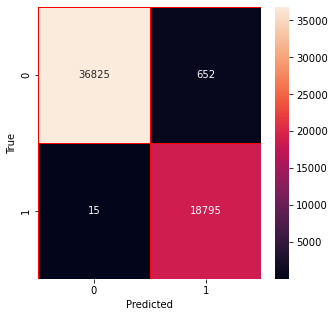

In [89]:
# confusion matrix
cm = confusion_matrix(y_test, predictions_knn)
f, ax = plt.subplots(figsize = (5,5))

sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f", ax = ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Tune Hyperparameters and Fit Decision Tree Model

In [61]:
# create decision tree classifer object
dt = DecisionTreeClassifier()

# hyperparamter tuning options
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(criterion = criterion, max_depth = max_depth)

# grid search to determine best number of neighbors
# halving grid search is used to decrease computation time due to large dataset size
grid = HalvingGridSearchCV(dt, parameters, cv = 5, 
                           scoring = 'accuracy', return_train_score = False).fit(features_scaled, y_train)

# print best hyperparameters
crit = grid.best_params_['criterion']
depth = grid.best_params_['max_depth']
print('Optimal Criterion:', crit)
print('Optimal Depth: ', depth)

Optimal Criterion: entropy
Optimal Depth:  12


In [62]:
# fit decision tree model
dt = DecisionTreeClassifier(criterion = crit, max_depth = depth)
dt_model = dt.fit(features_pca_train, y_train)

In [63]:
predictions_dt = dt_model.predict(features_pca_test)      # make predictions using test data

In [64]:
# print model accuracy
print('Model Accuracy: {}%'.format(round(metrics.accuracy_score(y_test, predictions_dt) * 100, 5)))

Model Accuracy: 94.73591%


In [65]:
# find the model's auc score
print('Model AUC:', round(roc_auc_score(y_test, predictions_dt), 5))

Model AUC: 0.94722


In [66]:
# find the model's MCC
print('Model MCC:', round(matthews_corrcoef(y_test, predictions_dt), 5))

Model MCC: 0.88383


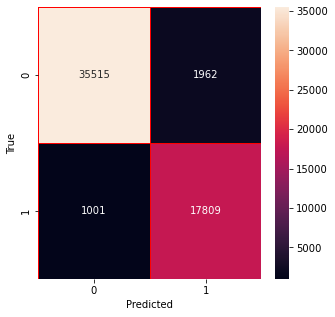

In [90]:
# confusion matrix
cm = confusion_matrix(y_test, predictions_dt)
f, ax = plt.subplots(figsize = (5,5))

sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f", ax = ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Tune Hyperparameters and Fit Random Forest Model

In [71]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = HalvingGridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, scoring = 'accuracy').fit(features_scaled, y_train)

In [72]:
# print best hyperparameters
bs = grid_search.best_params_['bootstrap']
depth = grid_search.best_params_['max_depth']
features = grid_search.best_params_['max_features']
sl = grid_search.best_params_['min_samples_leaf']
ss = grid_search.best_params_['min_samples_split']
estimators = grid_search.best_params_['n_estimators']
print('Optimal Bootstrap:', crit)
print('Optimal Depth: ', depth)
print('Optimal Features: ', features)
print('Optimal Samples Leaf: ', sl)
print('Optimal Samples Split: ', ss)
print('Optimal Estimators: ', estimators)

Optimal Bootstrap: entropy
Optimal Depth:  80
Optimal Features:  2
Optimal Samples Leaf:  3
Optimal Samples Split:  10
Optimal Estimators:  1000


In [75]:
# fit random forest model
rf = RandomForestClassifier(bootstrap = bs, max_depth = depth, max_features = features,
                         min_samples_leaf = sl, min_samples_split = ss, n_estimators = estimators)
rf_model = rf.fit(features_pca_train, y_train)

In [76]:
predictions_rf = rf_model.predict(features_pca_test)      # make predictions using test data

In [77]:
# print model accuracy
print('Model Accuracy: {}%'.format(round(metrics.accuracy_score(y_test, predictions_dt) * 100, 5)))

Model Accuracy: 94.73591%


In [78]:
# find the model's auc score
print('Model AUC:', round(roc_auc_score(y_test, predictions_dt), 5))

Model AUC: 0.94722


In [79]:
# find the model's MCC
print('Model MCC:', round(matthews_corrcoef(y_test, predictions_dt), 5))

Model MCC: 0.88383


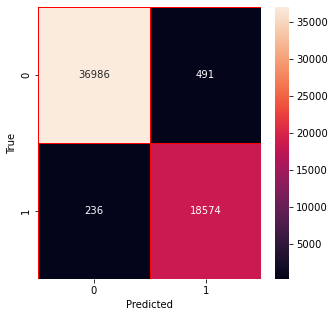

In [91]:
# confusion matrix
cm = confusion_matrix(y_test, predictions_rf)
f, ax = plt.subplots(figsize = (5,5))

sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f", ax = ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Conclusion

After fitting both a K-Nearest Neighbor algorithm and a Decision Tree Classification model on our data, we find a model accuracy of 98.74%, an AUC of 0.99, and a MCC of 0.97 for our KNN model, and a model accuracy of 94.69%, an AUC of 0.95, and a MCC of 0.88 for our decision tree model. Although the accuracies are high for both models, the imbalanced nature of the data makes this a poor metric for determining model fit. However, based on the accuracy, we can conclude that both of models do take into account the minority outcome. Looking instead toward the AUC and MCC, the KNN model performs better in both cases. Although the model AUC for both the KNN and decision tree model are close, the MCC is further off, with the decision tree model performing more poorly. Thus, the KNN model is a stronger model for predicting termination based on the chosen features. 